In [1]:
import spacy
import string

def clean_text(corpus):
    # Remove punctuations from the corpus
    translator = str.maketrans('', '', string.punctuation)
    corpus = corpus.translate(translator)

    # Remove digits from the corpus
    remove_digits = str.maketrans('', '', string.digits)
    corpus = corpus.translate(remove_digits)
    return corpus

nlp = spacy.load('en_core_web_sm')



In [30]:
with open("scripts_concat.txt", "r") as f:
    scripts_string = f.read()

corpus = clean_text(scripts_string)


print("Tamaño del corpus: {}".format(len(corpus)))
print("nlp max length: {}".format(nlp.max_length))

corpus_chunk = [corpus[i:i+nlp.max_length] for i in range (0,len(corpus), nlp.max_length)]


# we process chunks of the corpus accoding to the max length of nlp

docs = []
for chunk in corpus_chunk:
    doc = nlp(chunk)
    docs.append(doc)



Tamaño del corpus: 4740654
nlp max length: 1000000


# Análisis del texto

In [31]:
words = []
nouns = []
verbs = []
people = []
orgs = []

for doc in docs:
    for token in doc:
        words.append(token.text)
        if token.pos_ == "VERB":
            verbs.append(token.text)
            
        if token.pos_ == "NOUN":
            nouns.append(token.text)


for doc in docs:
    for ent in doc.ents:
        if ent.label_ == "ORG":
            orgs.append(ent.text)
        if ent.label_ == "PERSON":
            people.append(ent.text)

print("Total words: ", len(words))
print("Total verbs: ", len(verbs))
print("Total nouns: ", len(nouns))
print("Total people: ", len(people))
print("Total organizations: ", len(orgs))

Total words:  656598
Total verbs:  88254
Total nouns:  85804
Total people:  17500
Total organizations:  6215


## Contando palabras

In [32]:
from collections import Counter
from collections import OrderedDict

def sort_by_frequency(data,reverse=True):
    """ 
    Function to sord the data by its frequency
    Returns ordered dictionary
    Default: Sort in descending order
        
    """
    data_with_freq = dict(Counter(data))
    data_sorted_by_freq = OrderedDict(sorted(data_with_freq.items(), key=lambda x: x[1],reverse=reverse))
    
    return data_sorted_by_freq

In [33]:


words_frequency = sort_by_frequency(words)
nouns_frequency = sort_by_frequency(nouns)
verbs_frequency  = sort_by_frequency(verbs)
people_frequency = sort_by_frequency(people)
orgs_frequency = sort_by_frequency(orgs)

#print(verbs_frequency)

# Analizando Bigramas

In [7]:
import nltk

def create_bigram(tokens):
    # Using words token generated from spacy to find bigram
    bigrams_ = list(nltk.bigrams(tokens))
    # Convert generator into list of tuples of bigram 
    bigrams = [" ".join(bigram) for bigram in list(bigrams_)]

    return bigrams

#bigrams = create_bigram(words)

def get_racist_bigrams(bigrams):
    with open("racist_slang.txt", "r") as f:
        racist_slang_list = f.read().split("\n")
    
    racist_bigrams = []
    for bigram in bigrams:
        if any(word in bigram for word in racist_slang_list):
            racist_bigrams.append(bigram)
    
    return racist_bigrams



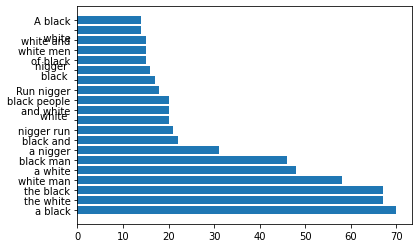

In [19]:
import numpy as np
import matplotlib.pyplot as plt


def get_top_n_from_order_dict(ordered_dict,n):
    """ Function to find n top object from ordered dictionary"""
    return [list(ordered_dict.items())[i] for i in range(n)]


def visualize_list_of_tuple(data):
    """"""
    list1, list2 = zip(*data)
    y_pos = np.arange(len(list1))
    plt.barh(y_pos, list2, align='center' )
    plt.yticks(y_pos, list1)
    plt.show()

top_racist_bigrams = get_top_n_from_order_dict(sort_by_frequency(get_racist_bigrams(bigrams)) , 20)
# The most popular rascist slurs
visualize_list_of_tuple(top_racist_bigrams)

# Clustering

## Clustering con monogramas

In [21]:
import spacy
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter



NUM_CLUSTERS = 10

# funcion para normalizar el oraciones


def normalize_sentence(span):
    # sacamos stopwords y signos de puntuación
    words = [t for t in span if not t.is_punct | t.is_stop]
    # nos quedamos con tokens alfabéticos y con largo considerable
    lexical_tokens = [t for t in words if len(t.orth_) > 3 and
                      t.orth_.isalpha()]

    # removemos pronombres
    cleaned_lemmas = [tok.lemma_.lower()
                      for tok in lexical_tokens if tok.pos_ != 'PRON']

    return cleaned_lemmas


def show_results(vocabulary, model):
    # Show results
    c = Counter(sorted(model.labels_))
    print("\nTotal clusters:", len(c))
    for cluster in c:
        print("Cluster#", cluster, " - Total words:", c[cluster])

    # Show top terms and words per cluster
    print("Top words per cluster:")
    print()

    keysVocab = list(vocabulary.keys())
    for n in range(len(c)):
        print("Cluster %d" % n)
        print("Words:", end='')
        word_indexs = [i for i, x in enumerate(list(model.labels_)) if x == n]
        for i in word_indexs:
            print(' %s' % keysVocab[i], end=',')
        print()
        print()

    print()



lemmatized_sentences = []

for doc in docs:
    for span in doc.sents:
        lemmatized_sentences.append(normalize_sentence(span))


# entrenamos un modelo de word embeddings neuronales
model = Word2Vec(lemmatized_sentences, min_count=1)
vocabulary = model.wv.key_to_index

# vectores que conseguimos del modelo
vectors = []
for word in vocabulary:
    vectors.append(model.wv[word])

matrix = np.array(vectors)
print("Matrix shape:", matrix.shape)

# normalizamos matriz y reducimos dimensionalidad quitando columnas con poca varianza

matrix_normed = matrix / matrix.max(axis=0)

variances = np.square(matrix_normed).mean(axis=0) - \
    np.square(matrix_normed.mean(axis=0))
VarianzaMin = 0.001
red_matrix = np.delete(matrix_normed, np.where(
    variances < VarianzaMin), axis=1)


# Utilizamos el algoritmo de K-means de scikit-learn
k_means_model = KMeans(n_clusters=NUM_CLUSTERS, init = "k-means++",max_iter=150,n_init=1)
k_means_model.fit(red_matrix)


#show_results(vocabulary, k_means_model)

Matrix shape: (18771, 100)


KMeans(max_iter=150, n_clusters=10, n_init=1)

## Clustering sobre scripts completos

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import time
from sklearn.cluster import KMeans




class DocumentCluster:
    """Class to cluster document"""
    def __init__(self,model,data,labels):
        self.model = model
        self.data = data
        self.labels = labels
        self.model_name = self._get_model_name()
        
        self.cluster_pipeline = None
        
    
    def _get_model_name(self):
        """Get name of model being used"""
        model_name = str(self.model).split('(')[0]
        return model_name
            

    
    def train_model(self,ngram,use_idf):
        """ 
            Train model
            ngram: int
            use_idf: bool
            analyzer: string
        
        """
        current_time = time.time()
        self._ngram = ngram
        self._use_idf = use_idf
        
        # Set a pipeline
        # 1. The first step of the pipeline is to find count vectorizer
        # Countvectorizer converts a collection of text documents to a matrix of token counts
        # This implementation produces a sparse representation of the counts
        # 2. We then use TfidfTransformr
        # TfidfTransformer transforms a count matrix to a normalized tf or tf-idf representation
        # Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency

        self.cluster_pipeline = Pipeline([('vect', CountVectorizer(ngram_range=(1,ngram), 
                analyzer="word")), ('tfidf', TfidfTransformer(use_idf=use_idf)), 
                ('model', self.model)])
        self._cluster = self.cluster_pipeline.fit(self.data)
        
        self._train_time = time.time() - current_time
        
        
        print("Training completed")
        print("Training time for {} : {} secs".format(self.model_name, self._train_time))
        
    
    def predict(self):
        """
        Predict cluster id for all clusters
        """
        self.label_id_dict = {}
        self.document_id_dict = {}
        self.cluster_id = []
        for i, document in enumerate(self.data):
            cluster_id = self.cluster_pipeline.predict([document])[0]
            self.label_id_dict.update({self.labels[i]:cluster_id})
            self.document_id_dict.update({document:cluster_id})
            self.cluster_id.append(cluster_id)
        
        return self.label_id_dict, self.document_id_dict

In [8]:
import json

with open("movies_scripts.json", "r") as f:
    data = json.load(f)

docs_text = list(map(lambda d: d["script"], data.values()))
labels = list(data.keys()) # the labels of each doc it's the name of the movie

cleaned_docs = []
for d in docs_text:
    cleaned_docs.append(clean_text(d).lower())


In [10]:
cluster_num = 5
model = KMeans(n_clusters=cluster_num, init = "k-means++",max_iter=150,n_init=1)

doc_cluster = DocumentCluster(data=cleaned_docs,model=model,labels=labels)

doc_cluster.train_model(ngram=2, use_idf=True)

result_label, result_docs = doc_cluster.predict()


result_label

Training completed
Training time for KMeans : 1.876147747039795 secs


{'gran torino': 4,
 'american history x': 1,
 'blackkklansman': 1,
 'School ties': 1,
 'race': 1,
 '42': 1,
 'django': 1,
 'red tails': 1,
 'the green mile': 1,
 'white chicks': 1,
 'glory road': 1,
 'ali': 1,
 'a time to kill': 1,
 'malcolm x': 1,
 'finding forrester': 2,
 'black cop': 1,
 'get out': 1,
 'Do the Right Thing': 1,
 'Fruitvale Station': 0,
 '12 Years a Slave': 1,
 'Born on the Fourth of July': 1,
 'forrest gump': 3,
 'Gangs of New York Script': 1}

In [14]:

# grouping texts by cluster

clusters_text = []
for i in range(cluster_num):
    text = " ".join([k for k,v in result_docs.items() if v == i])
    clusters_text.append(text)


# obteniendo los bigramas donde hay insinuaciones racistas 

def get_cluster_analysis_results(clusters_text):
    racist_bigrams_per_cluster = []
    for i, corpus in enumerate(clusters_text):
        tokens = corpus.split()
        bigrams = create_bigram(tokens)
        racist_bigrams_per_cluster.append(sort_by_frequency(get_racist_bigrams(bigrams)))



    return racist_bigrams_per_cluster

racist_bigrams_per_cluster = get_cluster_analysis_results(clusters_text)


for i in range(cluster_num):
    print("cluster {}".format(i))
    print(racist_bigrams_per_cluster[i])




cluster 0
OrderedDict([('a black', 11), ('black woman', 8), ('a white', 6), ('ass nigga', 5), ('black man', 3), ('my nigga', 3), ('old black', 2), ('white girl', 2), ('with white', 2), ('nigga sophina', 2), ('these niggas', 2), ('white man', 2), ('nigga huh', 2), ('looking black', 1), ('beautiful black', 1), ('charismatic black', 1), ('black male', 1), ('older black', 1), ('he black', 1), ('black katie', 1), ('hes white', 1), ('white but', 1), ('of black', 1), ('black people', 1), ('white collared', 1), ('white people', 1), ('black card', 1), ('black barber', 1), ('small white', 1), ('white bandage', 1), ('stocky white', 1), ('white inmate', 1), ('white boy', 1), ('birthday nigga', 1), ('ceephus black', 1), ('black uniforms', 1), ('uniforms black', 1), ('black players', 1), ('players black', 1), ('black coach', 1), ('black wife', 1), ('white rice', 1), ('black guy', 1), ('all white', 1), ('white dudes', 1), ('black face', 1), ('niggas brought', 1), ('nigga we', 1), ('nigga brandon', 1)

# Clustering sobre diálogos de los scripts

In [34]:
lines = []
labels = []

for doc in docs:

    for tuple in enumerate(doc.sents):
        lines.append(tuple[1].text)
        labels.append(tuple[0])

In [6]:
cluster_num = 4
model = KMeans(n_clusters=cluster_num, init = "k-means++",max_iter=150,n_init=1)

doc_cluster = DocumentCluster(data=lines,model=model,labels=labels)

doc_cluster.train_model(ngram=2, use_idf=True)

result_label, result_docs = doc_cluster.predict()




Training completed
Training time for KMeans : 2.585571527481079 secs


In [7]:
# grouping texts by cluster

clusters_text = []
for i in range(cluster_num):
    text = " ".join([k for k,v in result_docs.items() if v == i])
    clusters_text.append(text)

# obteniendo los bigramas donde hay insinuaciones racistas 

def get_cluster_analysis_results(clusters_text):
    racist_bigrams_per_cluster = []
    for i, corpus in enumerate(clusters_text):
        tokens = corpus.split()
        bigrams = create_bigram(tokens)
        racist_bigrams_per_cluster.append(sort_by_frequency(get_racist_bigrams(bigrams)))



    return racist_bigrams_per_cluster


racist_bigrams_per_cluster = get_cluster_analysis_results(clusters_text)


"""
for i in range(cluster_num):
    print("cluster {}".format(i))
    print(len(racist_bigrams_per_cluster[i]))
    print(racist_bigrams_per_cluster[i])
"""



NameError: name 'create_bigram' is not defined

## Yet another clustering

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(lines)


In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

### Usamos el Elbow method para determinar una buena cantidad de clusters

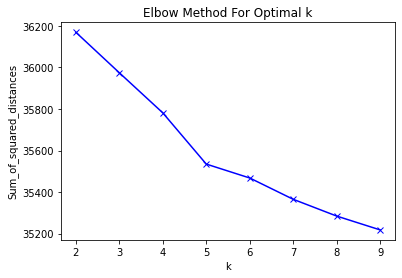

In [37]:


Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



In [38]:
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_

lines_clustering = sorted(list(zip(lines,labels)), key = lambda x: x[1])

#for t in lines_clustering:
#    print(t)


lines_clustering_df=pd.DataFrame(list(zip(lines,labels)),columns=['title','cluster'])
#print(lines_clustering_df.sort_values(by=['cluster']))



Cluster: 0
Titles
       \n\n\n\n\n                                 
GRAN TORINO\n\n\n\n                            ...
FADE IN\n\n\n\n          INT CHURCH\n\n\n      ...
\n\n\n          OLDER MAN\n\n          Im real ...
         Walt She was a real peach\n\n\n          
WALT\n\n          Thanks for coming Al\n          
                                 belly button ring
                                  \n\n\n          
                               STEVE\n\n          
Yeah well your kids wearing a\n          Timber...
                               STEVE\n\n          
My point is that theres nothing\n          anyo...
        What is this thing we call\n          life
\n\n\n          WALT\n\n          Jesus\n      ...
                               STEVE\n\n          
Yeah well I spose they knew\n          thered b...
Dad\n\n\n          WALT\n\n          Naw we nee...
                                  \n\n\n          
JOSH\n\n          �Third Platoon E company Marc...
             

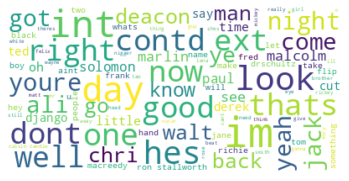

Cluster: 1
Titles
                                WALT\n\n          
                                WALT\n\n          
                \n\n\n          WALT\n\n          
                \n\n\n          WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
BACK ON WALT\n\n\n\n          \n\n\n\n         ...
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
                                WALT\n\n          
Walt downs a 

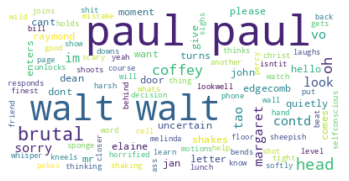

Cluster: 2
Titles
He cant even tone it\n          down at Moms fu...
                 Or\n          is it the beginning
I think\n          Ill go downstairs and get so...
No its Grandpa Walt\n          Josh turns the p...
The Gran Torino is in mint condition It has bee...
\n          Walt starts to step away but Father...
FATHER JANOVICH\n\n          It is\n          W...
Its always RiceBurner this or\n          JapBug...
\n\n\n          CUT TO\n\n\n\n          INT GAR...
           It puts him on the spot\n\n\n          
WALT\n\n          I have to hand it to you Padr...
It becomes\n          a pushing rolling surging...
WALT\n\n          Dont think for a second I won...
The doorbell rings Walt opens it to find Father...
you It seems that it would do\n          you go...
                                   and you know it
God it\n          gets so old\n\n\n          TA...
My name Its �take your crude\n          overly ...
                                  He aint worth it
            I

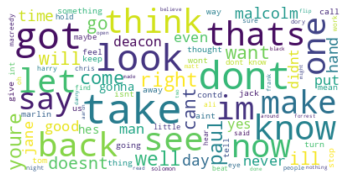

Cluster: 3
Titles
What do you expect Dads still\n          living...
\n\n\n          MITCH\n\n          What are we ...
Dont you think hell get in\n          trouble b...
\n\n\n          STEVE\n\n          Why dont you...
\n          embarrassed\n\n\n          MITCH\n\...
                           Yes you\n\n\n          
WALT\n\n\n\n          \n\n\n\n          ASHLEY\...
Its only been in here since\n          before y...
So what are you like going to do\n          wit...
Who the hell are you\n\n\n          TAO\n\n    ...
                          you want\n\n\n          
TAO\n\n          Do you have jumper cables My\n...
           How you holding up Walt\n\n\n          
Your wife\n          and I became quite close t...
WALT\n\n          I appreciate your kindness to...
She said she\n          couldnt remember the la...
WALT\n\n          Kill you to buy American\n\n\...
     Did you see him look at the truck\n          
Well what do you expect The man\n          work...
Whatta you go

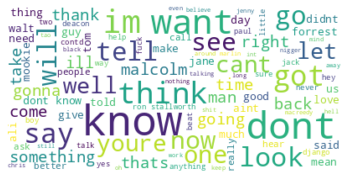

Cluster: 4
Titles
Walt Kowalski looks young for his age He has sl...
Nothing escapes his\n          hawklike eyes ey...
He expects\n          his granddaughter to dres...
Walt coughs He takes a handkerchief and wipes h...
He looks down and notices a speck of BLOOD on t...
The house is crammed with people following the ...
\n          Walt stands behind them with an arm...
Its snowing Walt puts on his coat he almost loo...
Walt carefully shovels his sidewalk He delibera...
And this is a problem for Walt because Walt is ...
At least he didnt say anything\n          this ...
                  He didnt have to\n\n\n          
Walt gets his guests engine running\n          ...
\n\n\n          PHONG\n\n\n\n          SUBTITLE...
\n\n\n\n\n          \n\n\n\n          \n\n     ...
He grabs Tao by the jacket and pulls him to his...
He pushes Tao backwards Tao falls back into the...
Polarski would turn over in\n          his grav...
Tao nods to an older woman rocking in a broken ...
\n\n\n\n     

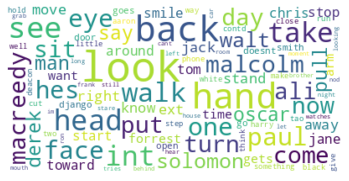

Cluster: 5
Titles
Okay Lets go help out our\n          little cousin
           Sure You know you seem okay\n          
                       its okay Im\n          here
                                      Are you okay
       Okay just put them on the porch\n          
Okay What are you good at\n\n\n          TAO\n\...
      Okay then\n\n\n          MITCH\n\n          
                                              Okay
                   Okay it was nice talking to you
Okay whats this\n          Tao points to a tool...
      Okay then\n\n\n          MITCH\n\n          
                                   Okay lets go in
Okay You go out come back in\n          and giv...
          Okay You owe me one Walt\n\n\n          
                                  Is everyone okay
                              okay\n\n\n          
\n\n\n          FATHER JANOVICH\n\n          Ar...
Okay\n          Tao doesnt answer\n\n\n        ...
   okay You wont do\n          anything without me
             

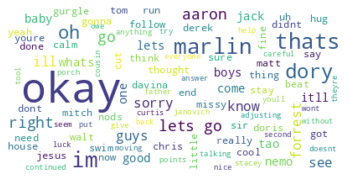

Cluster: 6
Titles
\n\n\n          \n\n\n\n          CONTINUED\n\n...
\n\n\n          \n\n\n\n          CONTINUED\n\n...
 NIGHT\n\n\n\n\n          \n\n\n\n          \n\...
\n\n\n\n          \n\n\n\n          \n\n\n\n   ...
Im going inside\n\n\n          \n\n\n\n        ...
\n\n\n\n          \n\n\n\n          \n\n\n\n   ...
\n\n\n\n          \n\n\n\n          \n\n\n\n   ...
WALT\n\n          Bullshit this is a bar what d...
FATHER JANOVICH\n\n          I dont know about ...
\n\n\n          \n\n\n\n          CONTINUED\n\n...
He exhales as he looks at his car\n\n\n        ...
\n\n\n\n          \n\n\n\n          \n\n\n\n   ...
\n\n\n          PHONG\n\n\n\n          SUBTITLE...
\n          A ceramic Lawn Gnome is knocked ove...
\n\n\n          \n\n\n\n          CONTINUED \n\...
For what\n\n\n          \n\n\n\n          CONTI...
What were you thinking Someone\n          could...
But\n          theres one thing youre way wrong...
\n\n\n\n          \n\n\n\n          \n\n\n\n   ...
\n\n\n\n     

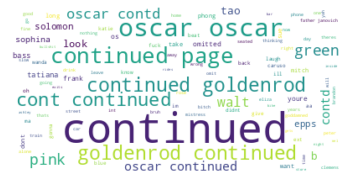

Cluster: 7
Titles
           Were at the funeral of Dorothy Kowalski
In attendance\n          are mostly old folks t...
Jesus Christ\n          Walts two sons MITCH an...
\n\n          Its inevitable Thats why we\n    ...
The choir sings the Beatitudes\n          Walt ...
                       And what is\n          life
A lot of people showed up after\n          the ...
Grandsons JOSH DANIEL and DAVID look through bo...
They hear someone coming downstairs By the time...
Grandpa Walt can I help you with\n          the...
\n\n\n          WALT\n\n          Id better sal...
The reason for this is that Walts neighbors are...
Next door to Walts house some sort of party is ...
WALT\n\n          Jesus Christ how many swamp r...
\n\n\n\n\n          \n\n\n\n          \n\n     ...
Wow Grandpa whend you get the\n          vintag...
WALT\n\n          Jesus Joseph and Mary\n      ...
The doorbell rings and Walt opens the door Stan...
What Speak up boy get the\n          shit out o...
\n          W

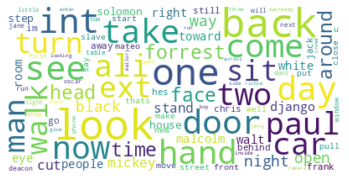

In [24]:
from wordcloud import WordCloud
result={'cluster':labels,'dialog lines':lines}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['dialog lines'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=lines_clustering_df[lines_clustering_df.cluster==k]['title']
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# Contextos indicadores de racismo usando Información mutua

In [2]:
with open("scripts_concat.txt", "r") as f:
    scripts_string = f.read()

corpus = clean_text(scripts_string)

corpus_chunk = [corpus[i:i+nlp.max_length] for i in range (0,len(corpus), nlp.max_length)]

docs = []
for chunk in corpus_chunk:
    doc = nlp(chunk)
    docs.append(doc)


In [3]:
racist_seeds = []

with open("racist_slang.txt", "r") as f:
    s = f.read()

racist_seeds = set(s.split("\n"))


In [13]:
movie_lines = [] # it contains all the lines of the scripts
racist_lines = [] # it contains the context of a racist line and the racist line
racist_indexes = []

for doc in docs:
    for sent in doc.sents:
        movie_lines.append(sent.text)
        if len(racist_seeds.intersection( set(sent.text.split(" "))  )) != 0:
            
            # we keep the context of the racist lines
            racist_lines.append(sent.text)
            racist_lines.append(movie_lines[-2])
            racist_lines.append(movie_lines[-3])
            racist_indexes.append(len(movie_lines) - 1)

# we obtain the next two lines of dialogue of a racist one
for i in racist_indexes:
    racist_lines.append(movie_lines[i+1])
    racist_lines.append(movie_lines[i+2])



word_count_racist_context = sort_by_frequency(" ".join(racist_lines).split())
word_count_total = sort_by_frequency(" ".join(movie_lines).split())


racist_bigrams_lines = create_bigram([item for sublist in list(map(lambda l: l.split(), racist_lines)) for item in sublist])
bigrams_lines = create_bigram([item for sublist in list(map(lambda l: l.split(), movie_lines)) for item in sublist])
word_count_racist_bigrams = sort_by_frequency(racist_bigrams_lines)
word_count_total_bigrams = sort_by_frequency(bigrams_lines)




In [14]:
word_count_racist_bigrams

OrderedDict([('of the', 336),
             ('in the', 294),
             ('to the', 222),
             ('on the', 182),
             ('from the', 128),
             ('in a', 123),
             ('white man', 123),
             ('the white', 117),
             ('at the', 116),
             ('is a', 105),
             ('the black', 103),
             ('with a', 97),
             ('a black', 87),
             ('and the', 86),
             ('out of', 81),
             ('nigger run', 73),
             ('a white', 72),
             ('to a', 70),
             ('with the', 70),
             ('of a', 68),
             ('CUT TO', 68),
             ('through the', 67),
             ('run well', 67),
             ('Run nigger', 67),
             ('black man', 66),
             ('CALVIN CANDIE', 63),
             ('of his', 61),
             ('on a', 61),
             ('into the', 59),
             ('is the', 59),
             ('in his', 54),
             ('on his', 54),
             ('for a', 52),


In [19]:
from numpy import log2

def imp(num_ocur_rac_context, num_ocur_total):
    amount_words_rc = sum(map(lambda s: len(s.split()), racist_lines))

    return log2(num_ocur_rac_context / (num_ocur_total * amount_words_rc))

imp_dict = {}

for rk in word_count_racist_context.keys():
    if rk in word_count_total.keys() and word_count_total[rk] > 10:
        imp_dict[rk] = imp(word_count_racist_context[rk], word_count_total[rk])
        #print("Palabra: {} - IMP: {}".format(rk, imp(word_count_racist_context[rk], word_count_total[rk])))

imp_dict = {k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

imp_dict

{'nigger': -15.560315684357937,
 'white': -15.761536897582527,
 'black': -15.8349822026788,
 'leaders': -15.905518631772557,
 'Run': -15.975907959663955,
 'nigga': -16.005054305323473,
 'devil': -16.01171803560448,
 'Charlie': -16.111969509239984,
 'slaver': -16.12053152274341,
 'community': -16.127911053109006,
 'miracle': -16.22744672665992,
 'ladder': -16.22744672665992,
 'Revised': -16.22744672665992,
 'bid': -16.22744672665992,
 'Calvins': -16.22744672665992,
 'powder': -16.33436193057643,
 'gal': -16.364950250409855,
 'BEMBRY': -16.455252644182732,
 'teaches': -16.468454826163715,
 'ARMY': -16.475374240103505,
 'FAN': -16.490481132493713,
 'religion': -16.490481132493713,
 'CHAPLAIN': -16.490481132493713,
 'Wallace': -16.490481132493713,
 'HUGE': -16.516953343854905,
 'Eskimo': -16.516953343854905,
 'ROY': -16.549374821547282,
 'SOPHIA': -16.549374821547282,
 'whites': -16.549374821547282,
 'believed': -16.549374821547282,
 'fancy': -16.568483644494986,
 'CROWD': -16.617393244975

In [17]:
# PMI for bigrams
imp_dict_bigrams = {}

for rk in word_count_racist_bigrams.keys():
    if rk in word_count_total_bigrams.keys() and word_count_total_bigrams[rk] > 10:
        imp_dict_bigrams[rk] = imp(word_count_racist_bigrams[rk], word_count_total_bigrams[rk])

imp_dict_bigrams = {k: v for k, v in sorted(imp_dict_bigrams.items(), key=lambda item: item[1], reverse=True)}

imp_dict_bigrams

{'run well': -14.331282537644459,
 'Run nigger': -14.331282537644459,
 'nigger run': -14.429939590558662,
 'well you': -14.56448171393749,
 'well the': -14.828897350169644,
 'better get': -15.189972021241257,
 'will get': -15.189972021241257,
 'white men': -15.22744672665992,
 'black people': -15.260613590595119,
 'white mans': -15.342923944079855,
 'white man': -15.351021411778452,
 'get away': -15.358691259938173,
 'the white': -15.486365024021481,
 'of black': -15.590016806044629,
 'you better': -15.60595834991365,
 'the black': -15.62840904072704,
 'black man': -15.737641458979104,
 'a white': -15.757961443358699,
 'white people': -15.768015108022622,
 'a nigger': -15.812409227381076,
 'Muhammad is': -15.879523423239613,
 'If the': -15.905518631772557,
 'white and': -15.922592145131498,
 'The black': -15.927886444801011,
 'of white': -15.927886444801011,
 'black woman': -15.927886444801011,
 'with white': -15.927886444801011,
 'the Negro': -15.947338807467185,
 'white folks': -15.9

## Expandiendo la lista de palabras semilla racista

In [26]:
from shutil import copyfile

copyfile("racist_slang.txt", "expanded_racists_slang.txt")


with open("expanded_racists_slang.txt", "a") as f:
    for count, k in enumerate(imp_dict.keys()):
        # we only get the first 45 words
        if count == 45:
            break
        f.write(k + "\n")



# Clasificando líneas de diálogo para alimentar a la Regresión Logística

In [42]:
# Run this cell to use the expand list of racist slang
with open("expanded_racists_slang.txt", "r") as f:
    s = f.read()

racist_seeds = set(s.split("\n"))


In [43]:


classification = []

for line in lines_clustering:
    if len(racist_seeds.intersection(line[0].split())) == 0:
        classification.append(["not_racist", line[0]])
    else:
        classification.append(["racist", line[0]])

len(list(filter(lambda l: l[0] == "racist",  classification)))

1377

In [44]:
import csv

header = ['racist/not_racist', 'dialog_line']

with open('dialog_lines.csv', "w", encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(classification)
